In [74]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer

In [75]:
dir = ""

In [76]:
rating_df = pd.read_csv(dir + "rating_df.csv")

rating_df = rating_df.drop('Unnamed: 0',axis=1)

In [77]:
match_df = pd.read_csv(dir + "match_clean.csv")

match_df = match_df.drop('Unnamed: 0',axis=1)

In [78]:
odds_col = match_df.columns[32:63].tolist()

odds_df = match_df[["date", "match_id", "home_team_id", "away_team_id"]]

for i in range(0, len(odds_col), 3):
    print(odds_col[i:i+3])
    
    cur_odds_df = match_df.loc[~match_df[odds_col[i]].isnull(), 
                               ["date", "match_id", "home_team_id"] + odds_col[i:i+3]]
    
    inv_odds = (1/cur_odds_df[odds_col[i:i+3]])

    booksum = inv_odds.sum(axis=1)

    margin = booksum - 1

    inv_odds["booksum"] = booksum

    bookprob = pd.concat([inv_odds[odds_col[i]]/inv_odds["booksum"], 
                          inv_odds[odds_col[i+1]]/inv_odds["booksum"], 
                          inv_odds[odds_col[i+2]]/inv_odds["booksum"]], axis=1)

    bookprob.columns = odds_col[i:i+3]
    
    bookprob["{}_bookspread".format(odds_col[i][:-1])] = bookprob[odds_col[i]] - bookprob[odds_col[i+2]]
    
    bookprob["{}_margin".format(odds_col[i][:-1])] = margin
    
    bookprob[["date", "match_id", "home_team_id"]] = cur_odds_df[["date", "match_id", "home_team_id"]]
    
    odds_df = odds_df.merge(bookprob, 
                            on=["date", "match_id", "home_team_id"],
                            how="left")

['B365H', 'B365D', 'B365A']
['BWH', 'BWD', 'BWA']
['IWH', 'IWD', 'IWA']
['LBH', 'LBD', 'LBA']
['PSH', 'PSD', 'PSA']
['WHH', 'WHD', 'WHA']
['SJH', 'SJD', 'SJA']
['VCH', 'VCD', 'VCA']
['GBH', 'GBD', 'GBA']
['BSH', 'BSD', 'BSA']


In [79]:
home_df = rating_df.loc[rating_df["home"]==1].drop(["home", "m_rating"], axis=1)
home_df.columns = ['league_id', 'season', 'date', 'stage',
                   'match_id', 'home_team_id', 'home_goal','home_m_rating']
home_df = home_df.sort_values(["league_id", "date", "match_id"])

away_df = rating_df.loc[rating_df["home"]==0].drop(["home", "m_rating"], axis=1)
away_df.columns = ['league_id', 'season', 'date', 'stage',
                   'match_id', 'away_team_id', 'away_goal','away_m_rating']

away_df = away_df.sort_values(["league_id", "date", "match_id"])

rating_df = home_df.merge(away_df, on=["league_id", "season", "date", "match_id", "stage"], how="left")

In [80]:
rating_df = rating_df[['league_id', 'season', 'date', 'stage', 'match_id', 'home_team_id',
                       'away_team_id', 'home_goal', 'away_goal', 'home_m_rating',
                       'away_m_rating']]

In [81]:
rating_df = rating_df.merge(odds_df, on=["date", "match_id", "home_team_id", "away_team_id"])

rating_df["rating_home_v_against"] = rating_df["home_m_rating"] - rating_df["away_m_rating"] 

rating_df["goal_home_v_against"] = rating_df["home_goal"] - rating_df["away_goal"] 

In [100]:
s = 20
rating_df.loc[rating_df["stage"]>=s, ["BS_bookspread", "rating_home_v_against"]].corr()

,BS_bookspread,rating_home_v_against
BS_bookspread,1.000000,0.892928
rating_home_v_against,0.892928,1.000000


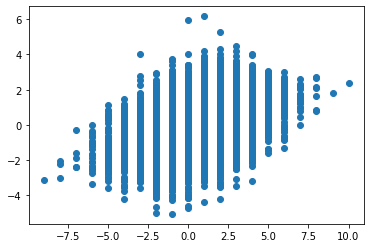

In [10]:
plt.scatter(rating_df.loc[rating_df["stage"]>=s, "goal_home_v_against"], 
            rating_df.loc[rating_df["stage"]>=s, "rating_home_v_against"])

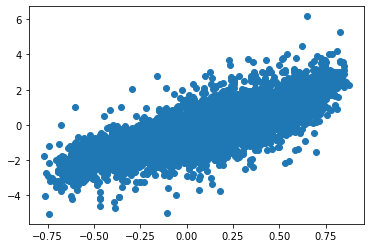

In [11]:
plt.scatter(rating_df.loc[rating_df["stage"]>=s, "BS_bookspread"], 
            rating_df.loc[rating_df["stage"]>=s, "rating_home_v_against"])

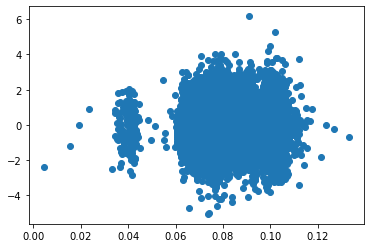

In [12]:
plt.scatter(rating_df.loc[rating_df["stage"]>=s, "GB_margin"], 
            rating_df.loc[rating_df["stage"]>=s, "rating_home_v_against"])

In [13]:
rating_df.groupby("league_id")["stage"].nunique()

league_id
1        34
1729     38
4769     38
7809     34
10257    38
13274    34
15722    30
17642    34
19694    38
21518    38
24558    36
Name: stage, dtype: int64

In [14]:
round(rating_df.groupby("stage")["GB_margin"].mean().sort_index(), 2)

stage
1.0     0.09
2.0     0.09
3.0     0.09
4.0     0.08
5.0     0.08
6.0     0.08
7.0     0.08
8.0     0.08
9.0     0.08
10.0    0.08
11.0    0.08
12.0    0.08
13.0    0.08
14.0    0.08
15.0    0.08
16.0    0.08
17.0    0.08
18.0    0.08
19.0    0.08
20.0    0.08
21.0    0.08
22.0    0.08
23.0    0.08
24.0    0.08
25.0    0.08
26.0    0.08
27.0    0.08
28.0    0.08
29.0    0.08
30.0    0.08
31.0    0.08
32.0    0.08
33.0    0.08
34.0    0.08
35.0    0.08
36.0    0.08
37.0    0.08
38.0    0.08
Name: GB_margin, dtype: float64

In [15]:
round(rating_df.groupby("stage")["GB_bookspread"].mean().sort_index(), 2)

stage
1.0     0.14
2.0     0.18
3.0     0.15
4.0     0.16
5.0     0.15
6.0     0.16
7.0     0.14
8.0     0.18
9.0     0.15
10.0    0.16
11.0    0.15
12.0    0.15
13.0    0.17
14.0    0.15
15.0    0.17
16.0    0.14
17.0    0.18
18.0    0.15
19.0    0.17
20.0    0.16
21.0    0.15
22.0    0.18
23.0    0.15
24.0    0.17
25.0    0.15
26.0    0.15
27.0    0.16
28.0    0.16
29.0    0.15
30.0    0.16
31.0    0.16
32.0    0.16
33.0    0.19
34.0    0.14
35.0    0.17
36.0    0.16
37.0    0.17
38.0    0.14
Name: GB_bookspread, dtype: float64

In [16]:
np.round(rating_df[[o for o in rating_df.columns if o[-6:]=="margin"]].corr(), 2)

,B365_margin,BW_margin,IW_margin,LB_margin,PS_margin,WH_margin,SJ_margin,VC_margin,GB_margin,BS_margin
B365_margin,1.00,0.42,0.49,0.46,0.43,0.41,0.38,0.44,0.41,0.47
BW_margin,0.42,1.00,0.62,0.51,0.65,0.57,0.37,0.63,0.67,0.52
IW_margin,0.49,0.62,1.00,0.50,0.77,0.50,0.40,0.46,0.65,0.53
LB_margin,0.46,0.51,0.50,1.00,0.51,0.64,0.23,0.67,0.43,0.60
PS_margin,0.43,0.65,0.77,0.51,1.00,0.58,0.37,0.52,0.64,0.48
WH_margin,0.41,0.57,0.50,0.64,0.58,1.00,0.30,0.73,0.43,0.60
SJ_margin,0.38,0.37,0.40,0.23,0.37,0.30,1.00,0.27,0.51,0.40
VC_margin,0.44,0.63,0.46,0.67,0.52,0.73,0.27,1.00,0.43,0.63
GB_margin,0.41,0.67,0.65,0.43,0.64,0.43,0.51,0.43,1.00,0.58
BS_margin,0.47,0.52,0.53,0.60,0.48,0.60,0.40,0.63,0.58,1.00


In [17]:
np.round(rating_df[[o for o in rating_df.columns if o[-6:]=="spread"]].corr(), 2)

,B365_bookspread,BW_bookspread,IW_bookspread,LB_bookspread,PS_bookspread,WH_bookspread,SJ_bookspread,VC_bookspread,GB_bookspread,BS_bookspread
B365_bookspread,1.00,1.00,0.99,1.00,1.00,1.00,1.00,1.00,1.00,1.00
BW_bookspread,1.00,1.00,0.99,0.99,1.00,1.00,1.00,1.00,1.00,1.00
IW_bookspread,0.99,0.99,1.00,0.99,0.99,0.99,0.99,0.99,0.99,0.99
LB_bookspread,1.00,0.99,0.99,1.00,1.00,1.00,0.99,1.00,1.00,1.00
PS_bookspread,1.00,1.00,0.99,1.00,1.00,1.00,1.00,1.00,1.00,1.00
WH_bookspread,1.00,1.00,0.99,1.00,1.00,1.00,1.00,1.00,1.00,1.00
SJ_bookspread,1.00,1.00,0.99,0.99,1.00,1.00,1.00,1.00,1.00,1.00
VC_bookspread,1.00,1.00,0.99,1.00,1.00,1.00,1.00,1.00,1.00,1.00
GB_bookspread,1.00,1.00,0.99,1.00,1.00,1.00,1.00,1.00,1.00,1.00
BS_bookspread,1.00,1.00,0.99,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [18]:
np.round(rating_df[[o for o in odds_col if o[-1]=="A"]].corr(), 2)

,B365A,BWA,IWA,LBA,PSA,WHA,SJA,VCA,GBA,BSA
B365A,1.00,1.00,0.99,0.99,1.00,1.00,1.00,1.00,1.00,1.00
BWA,1.00,1.00,0.99,0.99,1.00,0.99,0.99,1.00,1.00,0.99
IWA,0.99,0.99,1.00,0.99,0.99,0.99,0.99,0.99,0.99,0.99
LBA,0.99,0.99,0.99,1.00,1.00,0.99,0.99,0.99,0.99,0.99
PSA,1.00,1.00,0.99,1.00,1.00,1.00,1.00,1.00,1.00,1.00
WHA,1.00,0.99,0.99,0.99,1.00,1.00,0.99,1.00,1.00,0.99
SJA,1.00,0.99,0.99,0.99,1.00,0.99,1.00,1.00,1.00,0.99
VCA,1.00,1.00,0.99,0.99,1.00,1.00,1.00,1.00,1.00,0.99
GBA,1.00,1.00,0.99,0.99,1.00,1.00,1.00,1.00,1.00,1.00
BSA,1.00,0.99,0.99,0.99,1.00,0.99,0.99,0.99,1.00,1.00


In [19]:
rating_df["home_win"] = np.where(rating_df["home_goal"] > rating_df["away_goal"], 1, 0)
rating_df["home_lose"] = np.where(rating_df["home_goal"] < rating_df["away_goal"], 1, 0)

rating_df["away_win"] = np.where(rating_df["home_goal"] < rating_df["away_goal"], 1, 0)
rating_df["away_lose"] = np.where(rating_df["home_goal"] > rating_df["away_goal"], 1, 0)

home_df = rating_df[['league_id', 'season', 'date', 'stage', 'match_id', 'home_team_id',
                     'home_m_rating', 'home_win', 'home_lose', 'rating_home_v_against', 'B365_bookspread']]

home_df.columns = ['league_id', 'season', 'date', 'stage', 'match_id', 'team_id',
                   'm_rating', 'win', 'lose', 'rating_diff', 'B365_bookspread']
home_df["home"] = 1

away_df = rating_df[['league_id', 'season', 'date', 'stage', 'match_id', 'away_team_id',
                     'away_m_rating', 'away_win', 'away_lose', 'rating_home_v_against', 'B365_bookspread']]
away_df.columns = ['league_id', 'season', 'date', 'stage', 'match_id', 'team_id',
                   'm_rating', 'win', 'lose', 'rating_diff', 'B365_bookspread']
away_df['rating_diff'] = -away_df['rating_diff']
away_df["home"] = 0

stacked_df = pd.concat([home_df, away_df], axis=0)

<ipython-input-19-d15443e3ba3b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home_df["home"] = 1
<ipython-input-19-d15443e3ba3b>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  away_df['rating_diff'] = -away_df['rating_diff']
<ipython-input-19-d15443e3ba3b>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

In [20]:
stacked_df = stacked_df.sort_values(["team_id", "date"])
stacked_df["cumulative_win"] = 0
stacked_df["cumulative_lose"] = 0

for l in sorted(stacked_df["league_id"].unique()):
    for s in sorted(stacked_df["season"].unique()): 
        for t in sorted(stacked_df["team_id"].unique()):
            
            lst = stacked_df.loc[(stacked_df["season"]==s) & 
                                 (stacked_df["league_id"]==l) &
                                 (stacked_df["team_id"]==t), ["win", "lose"]]
            
            cumu_win = lst.groupby(lst.win.shift().eq(0).cumsum()).cumcount()
            cumu_lose = lst.groupby(lst.lose.shift().eq(0).cumsum()).cumcount()
            
            stacked_df.loc[(stacked_df["season"]==s) & 
                           (stacked_df["league_id"]==l) &
                           (stacked_df["team_id"]==t), "cumulative_win"] = cumu_win
            
            stacked_df.loc[(stacked_df["season"]==s) & 
                           (stacked_df["league_id"]==l) &
                           (stacked_df["team_id"]==t), "cumulative_lose"] = cumu_lose

In [21]:
#stacked_df.to_csv("stacked_df.csv")

In [22]:
print(stacked_df.shape)

(52462, 14)


In [23]:
#stacked_df = pd.read_csv("stacked_df.csv")
#stacked_df = stacked_df.drop('Unnamed: 0',axis=1)
#stacked_df

In [24]:
stacked_df.loc[stacked_df["stage"]>1].groupby("cumulative_win")["win"].mean()

cumulative_win
0     0.355331
1     0.358221
2     0.421883
3     0.485052
4     0.533679
5     0.580808
6     0.619910
7     0.669173
8     0.651163
9     0.703704
10    0.763158
11    0.678571
12    0.588235
13    0.900000
14    0.857143
15    0.666667
16    0.500000
17    0.500000
18    1.000000
19    0.000000
Name: win, dtype: float64

In [25]:
stacked_df.loc[stacked_df["stage"]>1].groupby("cumulative_lose")["lose"].mean()

cumulative_lose
0     0.359846
1     0.380111
2     0.411587
3     0.438084
4     0.414266
5     0.482394
6     0.477612
7     0.366667
8     0.545455
9     0.727273
10    0.571429
11    0.333333
12    0.000000
Name: lose, dtype: float64

In [26]:
print(rating_df.shape)
rating_df = rating_df.loc[rating_df["match_id"].isin(set(stacked_df["match_id"]))]
print(rating_df.shape)

(26231, 67)
(26231, 67)


In [27]:
home_df = stacked_df.loc[stacked_df["home"]==1, ['league_id', 'season', 'date', 'stage',
                                                 'match_id','cumulative_win', 'cumulative_lose']]
home_df.columns = ['league_id', 'season', 'date', 'stage', 'match_id',
                   'home_cumulative_win', 'home_cumulative_lose']

print(rating_df.shape)
rating_df = rating_df.merge(home_df, on=['league_id', 'season', 'date', 'stage', 'match_id'], how="left")

away_df = stacked_df.loc[stacked_df["home"]==0, ['league_id', 'season', 'date', 'stage',
                                                 'match_id','cumulative_win', 'cumulative_lose']]

away_df.columns = ['league_id', 'season', 'date', 'stage', 'match_id',
                   'away_cumulative_win', 'away_cumulative_lose']

rating_df = rating_df.merge(away_df, on=['league_id', 'season', 'date', 'stage', 'match_id'], how="left")

print(rating_df.shape)

(26231, 67)
(26231, 71)


In [28]:
streak_df = stacked_df.loc[(stacked_df["cumulative_win"]>0) |
                           (stacked_df["cumulative_lose"]>0),
                           ["date", "team_id", "cumulative_win", "cumulative_lose"]]

In [29]:
r_df = rating_df[["date", "home_team_id", "away_team_id", "home_m_rating", "away_m_rating", "B365_bookspread"]]

r_df = r_df.sort_values("date")

stacked_df["prev_opp_sum_rating"] = 0
stacked_df["prev_opp_sum_bookspread"] = 0

In [30]:
for date, team, c_win, c_lose  in zip(streak_df["date"], streak_df["team_id"], 
                                      streak_df["cumulative_win"], streak_df["cumulative_lose"]):
    
    if c_win > c_lose:
        
        prev_opp_sum_rating_df = r_df.loc[(r_df["date"]<date) & 
                                  ((r_df["home_team_id"]==team) |
                                   (r_df["away_team_id"]==team))].tail(c_win)
        
    elif c_win < c_lose:
        
        prev_opp_sum_rating_df = r_df.loc[(r_df["date"]<date) & 
                                  ((r_df["home_team_id"]==team) |
                                   (r_df["away_team_id"]==team))].tail(c_lose)
        
    prev_opp_sum_rating = 0
    prev_opp_sum_bspread = 0

    for ht,at,hr,ar,bs in zip(prev_opp_sum_rating_df['home_team_id'], prev_opp_sum_rating_df['away_team_id'], 
                               prev_opp_sum_rating_df['home_m_rating'], prev_opp_sum_rating_df['away_m_rating'],
                               prev_opp_sum_rating_df["B365_bookspread"]):
        if ht == team:
            prev_opp_sum_rating += ar 
            prev_opp_sum_bspread -= bs
        elif at == team:
            prev_opp_sum_rating += hr
            prev_opp_sum_bspread += bs
            
            
    stacked_df.loc[(stacked_df["date"]==date) &
                   (stacked_df["team_id"]==team), "prev_opp_sum_rating"] = prev_opp_sum_rating
    
    stacked_df.loc[(stacked_df["date"]==date) &
                   (stacked_df["team_id"]==team), "prev_opp_sum_bookspread"] = prev_opp_sum_bspread
    

In [31]:
stacked_df["prev_opp_avg_rating"] = 0

stacked_df["prev_opp_avg_rating"] = np.where(stacked_df["cumulative_win"]>0,
                                            stacked_df["prev_opp_sum_rating"]/stacked_df["cumulative_win"],
                                            stacked_df["prev_opp_sum_rating"]/stacked_df["cumulative_lose"])

In [32]:
stacked_df["prev_opp_avg_bspread"] = 0

stacked_df["prev_opp_avg_bspread"] = np.where(stacked_df["cumulative_win"]>0,
                                            stacked_df["prev_opp_sum_bookspread"]/stacked_df["cumulative_win"],
                                            stacked_df["prev_opp_sum_bookspread"]/stacked_df["cumulative_lose"])

In [33]:
stacked_df["prev_opp_avg_rating"]=  stacked_df["prev_opp_avg_rating"].replace(np.nan, 0)

stacked_df["prev_opp_avg_bspread"]=  stacked_df["prev_opp_avg_bspread"].replace(np.nan, 0)

In [34]:
print(stacked_df.shape)

(52462, 18)


In [35]:
stacked_df.isnull().sum()

league_id                     0
season                        0
date                          0
stage                         0
match_id                      0
team_id                       0
m_rating                      0
win                           0
lose                          0
rating_diff                   0
B365_bookspread            6748
home                          0
cumulative_win                0
cumulative_lose               0
prev_opp_sum_rating           0
prev_opp_sum_bookspread    4836
prev_opp_avg_rating           0
prev_opp_avg_bspread          0
dtype: int64

In [36]:
# count number of matches so fat instead of using stage

In [37]:
stacked_df["match_num"] = 1
stacked_df = stacked_df.sort_values(["team_id", "date"])
stacked_df["match_num"] = stacked_df.groupby(["league_id", "season", "team_id"])["match_num"].cumsum()

In [38]:
np.mean(stacked_df["match_num"]!=stacked_df["stage"])

0.1096412641531013

In [39]:
#bin match_num by quantile

stacked_df = stacked_df.sort_values(["league_id", "date", "match_num"])

for l in sorted(stacked_df["league_id"].unique()):
    for s in sorted(stacked_df["season"].unique()):
        
        kbin = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy="quantile")
        kbin.fit(stacked_df.loc[(stacked_df["season"]==s) & (stacked_df["league_id"]==l), 
                                "match_num"].values.reshape(-1, 1))
        
        bins = kbin.transform(stacked_df.loc[(stacked_df["season"]==s) & (stacked_df["league_id"]==l),
                                             ["match_num"]].values.reshape(-1,1))
    
        stacked_df.loc[(stacked_df["season"]==s) & (stacked_df["league_id"]==l), "match_bin"] = bins


In [40]:
stacked_df.groupby(["league_id", "season"])["match_bin"].nunique().value_counts()

5    88
Name: match_bin, dtype: int64

In [41]:
stacked_df.groupby(["league_id", "season", "match_bin"]).agg({"match_num": ["size", "min", "max"],
                                                             "date": ["min", "max"]}).head(30)

match_num                date            
                                   size min max         min         max
league_id season    match_bin                                          
1         2008/2009 0.0             108   1   6  2008-08-16  2008-10-05
                    1.0             126   7  13  2008-10-03  2008-11-29
                    2.0             126  14  20  2008-11-28  2009-02-07
                    3.0             126  21  27  2009-02-06  2009-03-22
                    4.0             126  28  34  2009-04-04  2009-05-16
          2009/2010 0.0              75   1   5  2009-07-31  2009-09-13
                    1.0              90   6  11  2009-09-12  2009-10-25
                    2.0              75  12  16  2009-10-24  2009-12-13
                    3.0              90  17  22  2009-12-11  2010-02-07
                    4.0              90  23  28  2010-01-31  2010-03-21
          2010/2011 0.0              96   1   6  2010-07-30  2010-09-12
                    1.0              96   7  12  2010-09-17  2010-10-24
                    2.0              96  13  18  2010-10-29  2011-01-18
                    3.0              96  19  24  2010-12-10  2011-02-15
                    4.0              96  25  30  2011-02-05  2011-03-23
          2011/2012 0.0              96   1   6  2011-07-29  2011-09-11
                    1.0              96   7  12  2011-09-17  2011-10-30
                    2.0              96  13  18  2011-11-04  2011-12-18
                    3.0              96  19  24  2011-12-26  2012-02-05
                    4.0              96  25  30  2012-02-11  2012-03-21
          2012/2013 0.0              96   1   6  2012-07-28  2012-09-02
                    1.0              96   7  12  2012-09-14  2012-10-28
                    2.0              96  13  18  2012-10-30  2012-12-02
                    3.0              96  19  24  2012-12-07  2013-02-09
                    4.0              96  25  30  2013-02-02  2013-03-16
          2013/2014 0.0              96   1   6  2013-07-26  2013-09-01
                    1.0              96   7  12  2013-09-14  2013-10-27
                    2.0              96  13  18  2013-10-30  2013-12-08
                    3.0              96  19  24  2013-12-14  2014-02-02
                    4.0              96  25  30  2014-02-08  2014-03-16

In [42]:
stacked_df.groupby(["league_id", "season", "match_bin"]).agg({"match_num": ["size", "min", "max"],
                                                             "date": ["min", "max"]}).tail(30)

match_num                date            
                                   size min max         min         max
league_id season    match_bin                                          
24558     2010/2011 0.0              70   1   7  2010-07-17  2010-08-29
                    1.0              70   8  14  2010-09-11  2010-11-10
                    2.0              70  15  21  2010-11-13  2011-02-20
                    3.0              70  22  28  2011-02-26  2011-04-17
                    4.0              80  29  36  2011-04-19  2011-05-25
          2011/2012 0.0              60   1   6  2011-07-16  2011-08-21
                    1.0              70   7  13  2011-08-27  2011-10-27
                    2.0              59  14  19  2011-10-29  2012-02-19
                    3.0              63  20  26  2012-02-11  2012-04-04
                    4.0              72  27  34  2012-04-07  2012-05-23
          2012/2013 0.0              70   1   7  2012-07-13  2012-08-26
                    1.0              70   8  14  2012-09-01  2012-11-04
                    2.0              70  15  21  2012-11-03  2013-03-03
                    3.0              70  22  28  2013-03-02  2013-04-21
                    4.0              80  29  36  2013-04-27  2013-06-01
          2013/2014 0.0              70   1   7  2013-07-13  2013-09-22
                    1.0              70   8  14  2013-09-21  2013-11-03
                    2.0              70  15  21  2013-11-23  2014-02-22
                    3.0              70  22  28  2014-02-22  2014-04-06
                    4.0              80  29  36  2014-04-12  2014-05-18
          2014/2015 0.0              70   1   7  2014-07-19  2014-08-31
                    1.0              70   8  14  2014-09-13  2014-11-09
                    2.0              70  15  21  2014-11-08  2015-03-01
                    3.0              70  22  28  2015-02-28  2015-04-19
                    4.0              80  29  36  2015-04-25  2015-05-29
          2015/2016 0.0              70   1   7  2015-07-18  2015-08-30
                    1.0              70   8  14  2015-09-12  2015-11-01
                    2.0              70  15  21  2015-11-07  2016-02-28
                    3.0              70  22  28  2016-02-27  2016-04-17
                    4.0              80  29  36  2016-04-19  2016-05-25

In [43]:
#stacked_df.to_csv("stacked_df.csv")

In [44]:
stacked_df.head(10)

,league_id,season,date,stage,match_id,team_id,m_rating,win,lose,rating_diff,B365_bookspread,home,cumulative_win,cumulative_lose,prev_opp_sum_rating,prev_opp_sum_bookspread,prev_opp_avg_rating,prev_opp_avg_bspread,match_num,match_bin
4,1,2008/2009,2008-08-16,1.0,492480,4049,0.0,0,1,0.0,-0.133858,1,0,0,0.0,0.0,0.0,0.0,1,0.0
2,1,2008/2009,2008-08-16,1.0,492477,7947,0.0,0,1,0.0,-0.371927,1,0,0,0.0,0.0,0.0,0.0,1,0.0
3,1,2008/2009,2008-08-16,1.0,492479,8571,0.0,0,0,-0.0,0.158612,0,0,0,0.0,0.0,0.0,0.0,1,0.0
1,1,2008/2009,2008-08-16,1.0,492475,8635,0.0,1,0,-0.0,0.052015,0,0,0,0.0,0.0,0.0,0.0,1,0.0
1,1,2008/2009,2008-08-16,1.0,492475,9984,0.0,0,1,0.0,0.052015,1,0,0,0.0,0.0,0.0,0.0,1,0.0
2,1,2008/2009,2008-08-16,1.0,492477,9985,0.0,1,0,-0.0,-0.371927,0,0,0,0.0,0.0,0.0,0.0,1,0.0
5,1,2008/2009,2008-08-16,1.0,492481,9986,0.0,0,1,-0.0,0.088435,0,0,0,0.0,0.0,0.0,0.0,1,0.0
0,1,2008/2009,2008-08-16,1.0,492474,9994,0.0,0,0,-0.0,0.213075,0,0,0,0.0,0.0,0.0,0.0,1,0.0
4,1,2008/2009,2008-08-16,1.0,492480,9996,0.0,1,0,-0.0,-0.133858,0,0,0,0.0,0.0,0.0,0.0,1,0.0
3,1,2008/2009,2008-08-16,1.0,492479,9999,0.0,0,0,0.0,0.158612,1,0,0,0.0,0.0,0.0,0.0,1,0.0


In [45]:
stacked_df.groupby("cumulative_lose")["lose"].mean()

cumulative_lose
0     0.359753
1     0.380158
2     0.411765
3     0.438084
4     0.413699
5     0.482394
6     0.477612
7     0.366667
8     0.545455
9     0.727273
10    0.571429
11    0.333333
12    0.000000
Name: lose, dtype: float64

In [46]:
stacked_df.groupby("cumulative_win")["win"].mean()

cumulative_win
0     0.355443
1     0.358213
2     0.421672
3     0.485679
4     0.533679
5     0.581864
6     0.619910
7     0.669173
8     0.651163
9     0.703704
10    0.763158
11    0.678571
12    0.588235
13    0.900000
14    0.857143
15    0.666667
16    0.500000
17    0.500000
18    1.000000
19    0.000000
Name: win, dtype: float64

In [47]:
rating_df.columns

Index(['league_id', 'season', 'date', 'stage', 'match_id', 'home_team_id',
       'away_team_id', 'home_goal', 'away_goal', 'home_m_rating',
       'away_m_rating', 'B365H', 'B365D', 'B365A', 'B365_bookspread',
       'B365_margin', 'BWH', 'BWD', 'BWA', 'BW_bookspread', 'BW_margin', 'IWH',
       'IWD', 'IWA', 'IW_bookspread', 'IW_margin', 'LBH', 'LBD', 'LBA',
       'LB_bookspread', 'LB_margin', 'PSH', 'PSD', 'PSA', 'PS_bookspread',
       'PS_margin', 'WHH', 'WHD', 'WHA', 'WH_bookspread', 'WH_margin', 'SJH',
       'SJD', 'SJA', 'SJ_bookspread', 'SJ_margin', 'VCH', 'VCD', 'VCA',
       'VC_bookspread', 'VC_margin', 'GBH', 'GBD', 'GBA', 'GB_bookspread',
       'GB_margin', 'BSH', 'BSD', 'BSA', 'BS_bookspread', 'BS_margin',
       'rating_home_v_against', 'goal_home_v_against', 'home_win', 'home_lose',
       'away_win', 'away_lose', 'home_cumulative_win', 'home_cumulative_lose',
       'away_cumulative_win', 'away_cumulative_lose'],
      dtype='object')

In [48]:
#rating_df.to_csv("odds_df.csv")

In [49]:
lsw_df = stacked_df.groupby(["league_id", "season", "team_id"])["win"].sum().reset_index()

In [50]:
winners = lsw_df.sort_values("win").groupby(["league_id", "season"]).tail(1)

In [51]:
winners

,league_id,season,team_id,win
944,15722,2010/2011,10265,17
953,15722,2011/2012,8025,17
1007,15722,2014/2015,8673,17
1022,15722,2015/2016,8673,17
98,1,2014/2015,8342,17
...,...,...,...,...
1225,19694,2013/2014,9925,31
1280,21518,2009/2010,8634,31
1345,21518,2012/2013,8634,32
1324,21518,2011/2012,8633,32


In [52]:
winners["season_league_team"] = winners["season"].astype(str) + winners["league_id"].astype(str) + winners["team_id"].astype(str)

In [60]:
temp = stacked_df.sort_values("date").groupby(["league_id", "season", "team_id"]).tail(1)
temp = temp[["league_id", "season", "team_id", "cumulative_win", "cumulative_lose", "match_id"]]
temp["season_league_team"] = temp["season"].astype(str) + temp["league_id"].astype(str) + temp["team_id"].astype(str)

In [61]:
winners = winners.merge(temp, on=["league_id", "season", "team_id"], how="left")

In [62]:
winners

,league_id,season,team_id,win,season_league_team_x,cumulative_win_x,cumulative_lose_x,match_id_x,season_league_team_y,cumulative_win_y,cumulative_lose_y,match_id_y,season_league_team
0,15722,2010/2011,10265,17,2010/20111572210265,1,0,838863,2010/20111572210265,1,0,838863,2010/20111572210265
1,15722,2011/2012,8025,17,2011/2012157228025,2,0,1030944,2011/2012157228025,2,0,1030944,2011/2012157228025
2,15722,2014/2015,8673,17,2014/2015157228673,0,0,1722329,2014/2015157228673,0,0,1722329,2014/2015157228673
3,15722,2015/2016,8673,17,2015/2016157228673,0,0,1994853,2015/2016157228673,0,0,1994853,2015/2016157228673
4,1,2014/2015,8342,17,2014/201518342,2,0,1718053,2014/201518342,2,0,1718053,2014/201518342
...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,19694,2013/2014,9925,31,2013/2014196949925,0,0,1686231,2013/2014196949925,0,0,1686231,2013/2014196949925
84,21518,2009/2010,8634,31,2009/2010215188634,4,0,685202,2009/2010215188634,4,0,685202,2009/2010215188634
85,21518,2012/2013,8634,32,2012/2013215188634,4,0,1260308,2012/2013215188634,4,0,1260308,2012/2013215188634
86,21518,2011/2012,8633,32,2011/2012215188633,6,0,1052016,2011/2012215188633,6,0,1052016,2011/2012215188633


In [63]:
finals = temp.loc[temp["season_league_team"].isin(set(winners["season_league_team_x"])), "match_id"]
finals = rating_df.loc[rating_df["match_id"].isin(finals)]

In [64]:
finals.head()

,league_id,season,date,stage,match_id,home_team_id,away_team_id,home_goal,away_goal,home_m_rating,...,rating_home_v_against,goal_home_v_against,home_win,home_lose,away_win,away_lose,home_cumulative_win,home_cumulative_lose,away_cumulative_win,away_cumulative_lose
298,1,2008/2009,2009-05-16,34.0,493106,9987,8635,0.0,2.0,-0.169579,...,-1.466872,-2.0,0,1,1,0,0,2,1,0
512,1,2009/2010,2010-03-21,30.0,665769,9994,8635,0.0,4.0,-0.900925,...,-2.222888,-4.0,0,1,1,0,0,3,4,0
748,1,2010/2011,2011-03-20,30.0,838867,8635,9991,3.0,2.0,1.206092,...,0.645108,1.0,1,0,0,1,0,0,1,0
989,1,2011/2012,2012-03-21,30.0,1032926,8635,10000,2.0,1.0,1.100756,...,1.271454,1.0,1,0,0,1,0,0,1,0
1230,1,2012/2013,2013-03-16,30.0,1224217,9991,8635,1.0,1.0,-0.281600,...,-1.675467,0.0,0,0,0,0,0,1,1,0


In [68]:
finals.groupby(["home_cumulative_win"]).agg({"home_win": ["size", "sum", "mean"]})

home_win              
                        size sum      mean
home_cumulative_win                       
0                         60  25  0.416667
1                         11   7  0.636364
2                          4   2  0.500000
3                          2   2  1.000000
4                          3   3  1.000000
5                          3   3  1.000000
6                          2   2  1.000000
8                          1   1  1.000000
9                          1   0  0.000000
11                         1   1  1.000000

In [70]:
(7+2+2+3+3+2+1+1)/(11+4+2+3+3+2+1+1+1), (2+2+3+3+2+1+1)/(4+2+3+3+2+1+1+1)

(0.75, 0.8235294117647058)

In [67]:
finals.groupby(["away_cumulative_win"]).agg({"away_win": ["size", "sum", "mean"]})

away_win              
                        size sum      mean
home_cumulative_win                       
0                         60  24  0.400000
1                         11   4  0.363636
2                          4   1  0.250000
3                          2   0  0.000000
4                          3   0  0.000000
5                          3   0  0.000000
6                          2   0  0.000000
8                          1   0  0.000000
9                          1   0  0.000000
11                         1   0  0.000000

In [ ]:
finals.groupby(["home_cumulative_lose"]).agg({"home_lose": ["size", "sum", "mean"]})

In [ ]:
finals.groupby(["away_cumulative_lose"]).agg({"away_lose": ["size", "sum", "mean"]})

In [ ]:
winners.groupby("league_id")["cumulative_win"].mean()

In [ ]:
winners.groupby("league_id")["cumulative_lose"].mean()

In [ ]:
league_df = pd.read_csv(dir + "league.csv")

team_df = pd.read_csv(dir + "team.csv", encoding = "ISO-8859-1")

In [ ]:
league_df

In [ ]:
team_df.loc[team_df["team_id"]==9885]